In [3]:
import pymc as pm
import numpy as np
import arviz as az
from itertools import combinations

# 7. Coagulation*

An example of Bayesian ANOVA.

Adapted from [Unit 7: anovacoagulation.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/anovacoagulation.odc).

Here 24 animals are randomly allocated to 4 different diets,  but the numbers allocated to different diets are not the same. The coagulation time for blood is measured for each animal. Are the diet-based differences significant? Example from page 166 of [Statistics for Experimenters](https://pages.stat.wisc.edu/~yxu/Teaching/16%20spring%20Stat602/%5bGeorge_E._P._Box,_J._Stuart_Hunter,_William_G._Hu(BookZZ.org).pdf) {cite:t}`box2005statistics`.

In [4]:
# cut and pasted data from .odc file
# fmt: off
times = (62, 60, 63, 59, 63, 67, 71, 64, 65, 66, 68, 66, 71, 67, 68, 68, 56, 62,
         60, 61, 63, 64, 63, 59)
diets = (1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4)
# fmt: on

# create dictionary where each key is a diet and values are lists of times
data = {}
for key, val in zip(diets, times):
    data.setdefault(key, []).append(val)
data

{1: [62, 60, 63, 59],
 2: [63, 67, 71, 64, 65, 66],
 3: [68, 66, 71, 67, 68, 68],
 4: [56, 62, 60, 61, 63, 64, 63, 59]}

## Simple method

No loops! If you're using this style, 4 treatments is probably the max before it starts to get too annoying to type out.

In [5]:
with pm.Model() as m:
    mu0 = pm.Normal("mu_0", mu=0, tau=0.0001)
    tau = pm.Gamma("tau", 0.001, 0.001)

    alpha = pm.ZeroSumNormal("alpha", sigma=10, shape=4)

    mu_1 = mu0 + alpha[0]
    mu_2 = mu0 + alpha[1]
    mu_3 = mu0 + alpha[2]
    mu_4 = mu0 + alpha[3]

    pm.Normal("lik1", mu=mu_1, tau=tau, observed=data[1])
    pm.Normal("lik2", mu=mu_2, tau=tau, observed=data[2])
    pm.Normal("lik3", mu=mu_3, tau=tau, observed=data[3])
    pm.Normal("lik4", mu=mu_4, tau=tau, observed=data[4])

    onetwo = pm.Deterministic("α1-α2", alpha[0] - alpha[1])
    onethree = pm.Deterministic("α1-α3", alpha[0] - alpha[2])
    onefour = pm.Deterministic("α1-α4", alpha[0] - alpha[3])
    twothree = pm.Deterministic("α2-α3", alpha[1] - alpha[2])
    twofour = pm.Deterministic("α2-α4", alpha[1] - alpha[3])
    threefour = pm.Deterministic("α3-α4", alpha[2] - alpha[3])

    trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau, alpha]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [6]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,64.002,0.527,63.001,64.989,0.004,0.003,16804.0,14148.0,1.0
tau,0.178,0.057,0.079,0.284,0.000,0.000,16225.0,13057.0,1.0
alpha[0],-2.956,1.023,-4.909,-1.033,0.007,0.005,18953.0,14236.0,1.0
alpha[1],1.975,0.885,0.327,3.700,0.006,0.005,20308.0,15274.0,1.0
alpha[2],3.960,0.891,2.326,5.695,0.006,0.004,22633.0,14953.0,1.0
alpha[3],-2.979,0.808,-4.491,-1.433,0.005,0.004,24695.0,16552.0,1.0
α1-α2,-4.931,1.606,-7.999,-1.931,0.012,0.008,18919.0,13622.0,1.0
α1-α3,-6.915,1.608,-9.936,-3.912,0.012,0.008,19548.0,13791.0,1.0
α1-α4,0.023,1.515,-2.889,2.791,0.011,0.010,20838.0,15546.0,1.0
α2-α3,-1.984,1.433,-4.657,0.784,0.010,0.008,22336.0,15018.0,1.0


Text(0.5, 1.0, 'Ridgeplot of $\\alpha$ and contrasts')

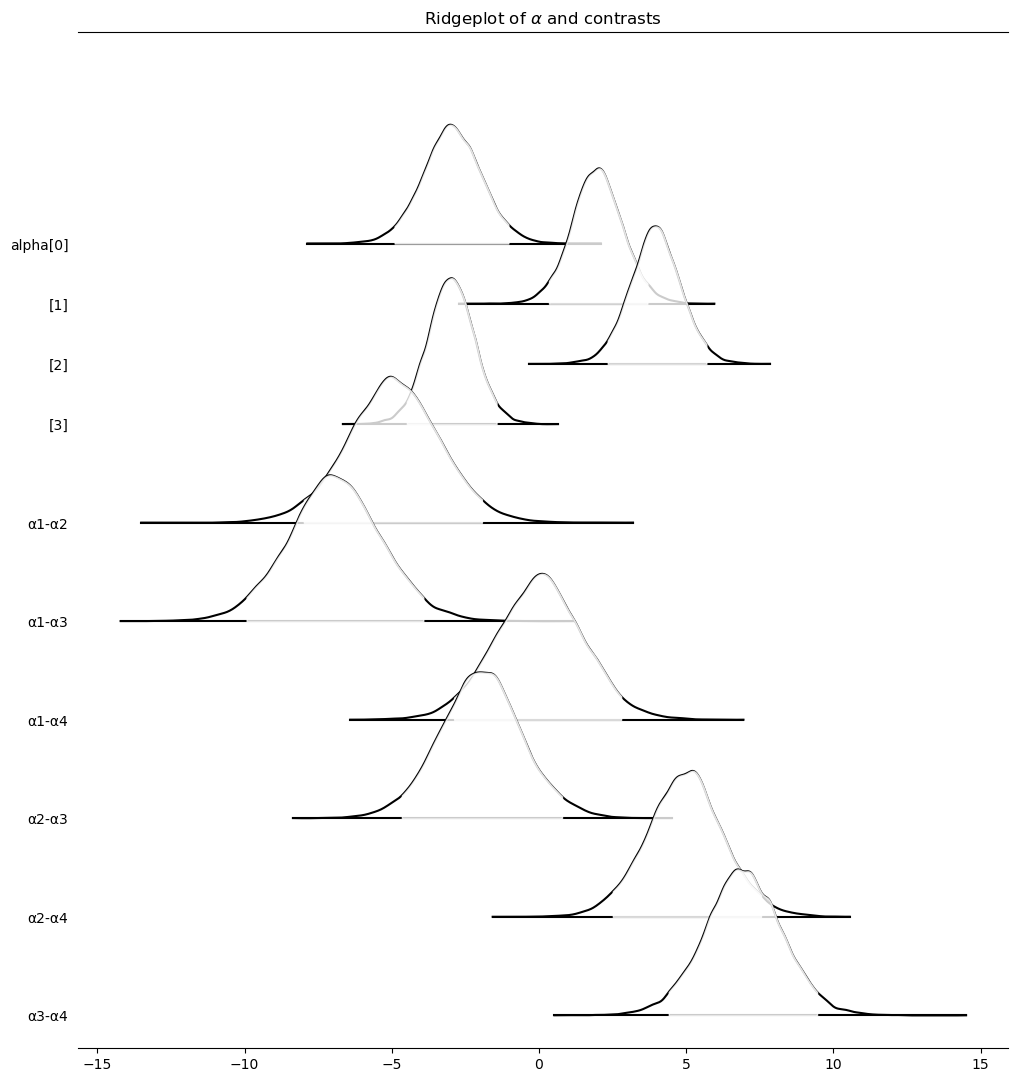

In [7]:
axes = az.plot_forest(
    trace,
    var_names=["~mu_0", "~tau"],
    kind="ridgeplot",
    combined=True,
    ridgeplot_truncate=False,
    ridgeplot_overlap=2,
    ridgeplot_alpha=0.8,
    colors="white",
)

axes[0].set_title("Ridgeplot of $\\alpha$ and contrasts")

## A more concise method
Not necessarily pretty, but easier to extend to more treatments. I'm interested in seeing other peoples' methods here; I feel like this could still be a lot cleaner.

In [8]:
from itertools import combinations


def contrasts(var):
    """Calculate differences between all pairs of levels with names like "alpha[i] - alpha[j]".

    var: pytensor.tensor.var.TensorVariable
    """
    name = var.name
    n = var.shape.eval()[0]  # use eval method to get shape within model context
    for i, j in combinations(range(n), 2):
        pm.Deterministic(f"{name}[{i}] - {name}[{j}]", var[i] - var[j])

In [9]:
with pm.Model() as m:
    mu0 = pm.Normal("mu0", mu=0, tau=0.0001)
    tau = pm.Gamma("tau", 0.001, 0.001)

    alphas = pm.ZeroSumNormal(f"αlpha", sigma=10, shape=4)
    mus = [
        pm.Deterministic(f"mu{i + 1}", mu0 + alpha) for i, alpha in enumerate(alphas)
    ]

    [
        pm.Normal(f"lik{i + 1}", mu=mus[i], tau=tau, observed=data[i + 1])
        for i, mu in enumerate(mus)
    ]

    contrasts(alphas)
    trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, tau, αlpha]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [13]:
az.summary(trace, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,64.010,0.527,63.023,65.006
tau,0.179,0.056,0.082,0.286
αlpha[0],-2.945,1.007,-4.846,-1.032
αlpha[1],1.981,0.880,0.367,3.686
αlpha[2],3.953,0.887,2.315,5.682
αlpha[3],-2.989,0.813,-4.515,-1.469
mu1,61.065,1.230,58.777,63.405
mu2,65.991,1.002,64.097,67.857
mu3,67.963,1.022,65.994,69.865
mu4,61.021,0.883,59.363,62.679


In [11]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Sun Mar 09 2025

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pytensor: 2.26.4

arviz: 0.20.0
pymc : 5.19.1
numpy: 1.26.4

